# Conecta ao google drive

In [13]:
import os
from google.colab import drive

drive.mount('/drive')
os.chdir('/drive/My Drive/UFAL/AM/Trabalho/Parte 1 - KNN/presentation')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [0]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KNeighborsRegressor
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [0]:
# load dataset 
dataset = pd.read_csv("datasets/WithoutSimilarProd.csv")
_dataset = dataset.drop(["TextSentiment", "SummarySentiment", "TaxaCurtidas", "TextSize", "ScoreNorm"],axis = 1)
user_dataset = pd.read_csv("datasets/UserDatasetWithoutClass.csv", index_col = 0)
user_dataset_not_norm = pd.read_csv("datasets/UserDatasetWithoutNorm.csv", index_col = 0)
centroids_dataframe = pd.read_csv("datasets/kmeans_centroids.csv")

dict_users_reviews = Counter(dataset["UserId"])
dataset_users_reviews = pd.DataFrame(data = [[id,num_reviews] for id,num_reviews in dict_users_reviews.items() if num_reviews< 10], columns = ["id", "reviews"])

In [0]:
def plot_clusters(data_clusters):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    cmap=plt.cm.get_cmap("Accent_r")
    
    cont=0
    for data in data_clusters:
        x = []
        y = []
        z = []
        for data_point in data:
            x.append(data_point[0])
            y.append(data_point[1])
            z.append(data_point[2])
        ax.scatter(x, y, z, marker='o',label="cluster "+str(cont))
        cont=cont+1

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.legend()
    
    return fig

In [0]:
# create clustes
def create_clusters(data, labels):
    cluster_1_users = []
    cluster_2_users = []
    for instance_transform, label in zip(data,labels):
        if label:
            cluster_1_users.append(instance_transform)
        else:
            cluster_2_users.append(instance_transform)
    
    return cluster_1_users,cluster_2_users


# Amazon product reviewers classification
<h3>
Link do dataset no kaggle: <a href="https://www.kaggle.com/snap/amazon-fine-food-reviews">https://www.kaggle.com/snap/amazon-fine-food-reviews</a><br>
Link da fonte original: <a href="https://snap.stanford.edu/data/web-Amazon.html">https://www.kaggle.com/snap/amazon-fine-food-reviews</a>
<h3>


# Sobre o dataset
## Os dados consistem em revisões de alimentos da amazom que abrangem um período de mais de 10 anos, incluindo todas as ~ 500.000 revisões até outubro de 2012. As revisões incluem informações sobre produtos e usuários, classificações e uma revisão de texto simples. Também inclui revisões de todas as outras categorias da Amazon.

# Descrição dos atributos

In [0]:
_dataset.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# Distribuição do score

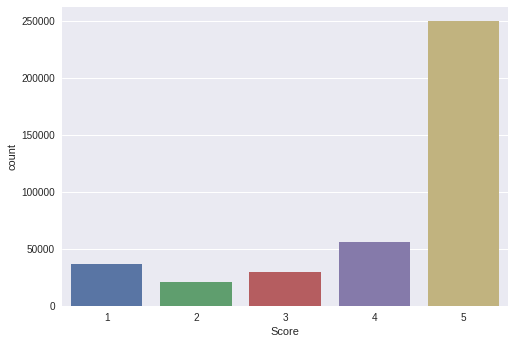

In [0]:
sb.countplot(data = dataset, x = "Score")

# Distribuição do números de reviews por usuários

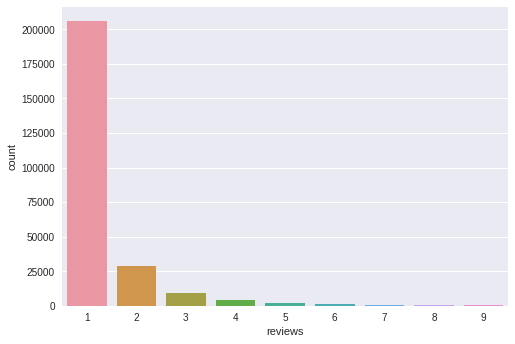

In [0]:
sb.countplot(data = dataset_users_reviews, x = "reviews", ax = ax)

# O que é uma boa review?

<ol>
    <span class="fragment" data-fragment-index="1"><li>Coerencia entre o score dado e o sentimento do texto</li></span>
    <span class="fragment" data-fragment-index="2"><li>Informações passadas pelo texto</li></span>
    <span class="fragment" data-fragment-index="3"><li>Quantidade de avaliações positivas e negativas</li></span>
    <span class="fragment" data-fragment-index="4"><li>Relação entre o score do usuário com os demais usuários</li></span>
    <span class="fragment" data-fragment-index="5"><li>Número de avaliações anteriores do usuário que fez a review</li></span>
    <span class="fragment" data-fragment-index="6"><li>Porcentagem de avaliações positivas</li></span>
</ol>

# Pré-processamento
### 1. Retirada dos produtos semelhantes
### 2. Seleção dos usuários com mais de 10 reviews
### 3. Análise de sentimento do Summary e Text
### 4.Tamanho do texto e  score normalizado
### 5. Extração de caracteristicas

# Produtos semelhantes
<table>
    <thead>
      <tr>
        <th>B005ZBZLT4</th>
        <th>B007Y59HVM</th>
      </tr>
   </thead>
  <tr>
    <td> <img src="img/cafe_0.jpg" alt="Drawing" style="width: 400px;"/> </td>
    <td> <img src="img/cafe_1.jpg" alt="Drawing" style="width: 400px;"/> </td>
  </tr>
</table>

# Seleção de usuários

In [0]:
# get the 2500 users with more reviews
most_common_counter = Counter(_dataset['UserId']).most_common(2500)

# ids from 2500 most common users by their reviews
most_common_user_ids = [user_i for user_i,_ in most_common_counter]

# create dataset with filtered users
most_common_user_by_reviews_dataset = _dataset.loc[_dataset['UserId'].isin(most_common_user_ids)]
most_common_user_by_reviews_dataset.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
11,14,B001GVISJM,A18ECVX2RJ7HUE,"willie ""roadie""",2,2,4,1288915200,fresh and greasy!,good flavor! these came securely packed... the...
12,15,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,5,1268352000,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...


# Análise de sentimento do Summary e Text

In [0]:
import textblob

dataset['TextSentiment'] = dataset.apply(lambda row: TextBlob(row.Text).sentiment.polarity , axis=1)
dataset['SummarySentiment'] = dataset.apply(lambda row: TextBlob(row.Summary).sentiment.polarity , axis=1)

# Mudar tamanho do texto e normalizar o score

In [0]:
dataset["TextSize"] = [len(text.split(" ")) for text in dataset["Text"]]
dataset['ScoreNorm'] = [(score_i-3)/2 for score_i in dataset['Score']]

dataset.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,TextSentiment,SummarySentiment,TaxaCurtidas,TextSize,ScoreNorm
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,0.450000,0.7,1.0,49,1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-0.033333,0.0,0.0,31,-1.0


# Extração de caracteristicas


<ul>
    <li><b>GroupLike</b> - Média da quantidade de likes dos produtos avaliados.</li>
    <li><b>GroupDeslike</b> - Média da quantidade de deslikes dos produtos avaliados.</li>
    <li><b>MeanTextSize</b>  - Média do tamanho do texto escrito nas reviews.</li>
    <li><b>NumberProducts</b> - Número de produtos avaliados pelo usuário.</li>
    <li><b>MeanDifferenceScoreBySentimentRate</b> - Média da diferença entre o score dado pelo usuário e a análise de sentimento do        seu texto.</li>
    <li><b>VarianceDifferenceScoreBySentimentRate</b> - Variância da diferença entre o score dado pelo usuário e a análise de            sentimento do seu texto</li>
    <li><b>MeanDiffUserScoreToProductScore</b> - Média da diferença entre o score do produto dado pelo usuário e a média do score dos     outros usuários avaliando o mesmo produto</li>
    <li><b>VarianceDiffUserScoreToProductScore</b> - variância da diferença entre o score do produto dado pelo usuário e a média do       score dos outros usuários avaliando o mesmo produto.</li>
    <li><b>MeanLikeParticipation</b> - Média da participação do usuário nas boas avaliações de um produto</li>
  <li><b>MeanReviewsWithLikes</b> Média das reviews do usuário que receberam avaliação positiva</li>
</ul>


In [0]:
# mean textsize column
user_dataset["MeanTextSize"] = users['TextSize'].agg(np.mean).tolist()
user_dataset['NumberProducts'] = users['ProductId'].agg(np.size).tolist()
user_dataset['MeanLike'], meanLikebins = pd.qcut(users['HelpfulnessNumerator'].agg(np.mean).tolist(), 5, labels = False, retbins = True)
user_dataset['Meandeslike'], Meandeslikebins = pd.qcut(users['Helpfuless'].agg(np.mean).tolist(), 5, labels = False, retbins = True)

print(meanLikebins)
print(Meandeslike)

[0, 0.4, 0.8, 1.4, 2.484, 40.21428571]
[-0.09090909, 0.10526316, 0.23076923, 0.36363636, 0.58333333, 8.625]


In [0]:
user_dataset.head(5)

,UserId,MeanTextSize,NumberProducts,MeanDifferenceScoreBySentimentRate,VarianceDifferenceScoreBySentimentRate,MeanLike,Meandeslike,MeanDiffUserScoreToProductScore,VarianceDiffUserScoreToProductScore,MeanLikeParticipation
0,A100WO06OQR8BQ,160.142857,35,0.324217,0.033890,1,4,0.256874,0.036600,0.040454
1,A1051DBTLWP5A2,192.647059,17,0.322921,0.013573,3,0,0.172642,0.031336,0.057382
2,A105S56ODHGJEK,149.857143,14,0.210000,0.017145,0,2,0.180998,0.019904,0.003400
3,A106Q1A6LGU4DP,141.600000,10,0.287599,0.013339,4,2,0.210665,0.016938,0.061429
4,A106ZCP7RSXMRU,120.882353,34,0.237055,0.012516,4,3,0.089998,0.012429,0.604175


# Média do tamanho do texto Boxplot

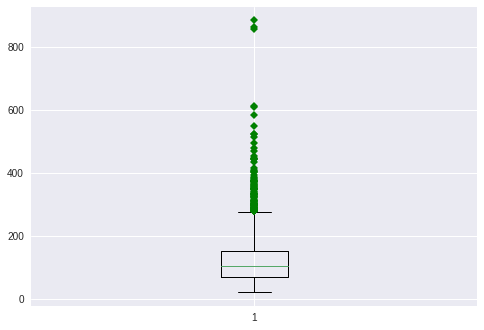

In [0]:
plt.boxplot(user_dataset_not_norm['MeanTextSize'],flierprops=dict(markerfacecolor='g', marker='D'))
plt.show()

# Número de produtos Boxplot

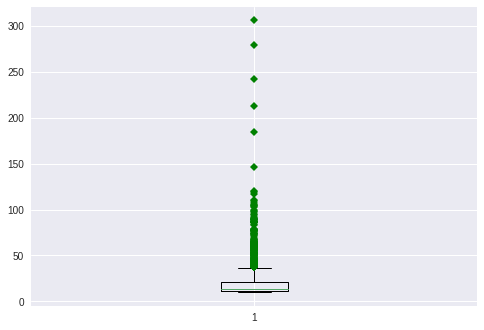

In [0]:
plt.boxplot(user_dataset_not_norm['NumberProducts'],flierprops=dict(markerfacecolor='g', marker='D'))
plt.show()

# Normalização 
$$
zi = \frac{xi - min(x)}{max(x) - min(x)}
$$

In [16]:
scale = lambda x, col_name: [(row-min(x[col_name]))/(max(x[col_name])-min(x[col_name])) for row in x[col_name]]

# number product and mean text size normalization
user_dataset['NumberProducts'] = scale(user_dataset, 'NumberProducts')
user_dataset['MeanTextSize'] = scale(user_dataset, 'MeanTextSize')
user_dataset['MeanLike'] = scale(user_dataset, 'MeanLike')
user_dataset['Meandeslike'] = scale(user_dataset, 'Meandeslike')

user_dataset.head(5)

,MeanTextSize,NumberProducts,MeanDifferenceScoreBySentimentRate,VarianceDifferenceScoreBySentimentRate,GroupLike,GroupDesLike,MeanReviewsWithLikes,MeanDiffUserScoreToProductScore,VarianceDiffUserScoreToProductScore,MeanLikeParticipation
UserId,,,,,,,,,,
A100WO06OQR8BQ,0.161068,0.084459,0.324217,0.033890,0.25,1.00,0.342857,0.256874,0.036600,0.040454
A1051DBTLWP5A2,0.198748,0.023649,0.322921,0.013573,0.75,0.00,0.235294,0.172642,0.031336,0.057382
A105S56ODHGJEK,0.149145,0.013514,0.210000,0.017145,0.00,0.50,0.142857,0.180998,0.019904,0.003400
A106Q1A6LGU4DP,0.139573,0.000000,0.287599,0.013339,1.00,0.50,0.200000,0.210665,0.016938,0.061429
A106ZCP7RSXMRU,0.115556,0.081081,0.237055,0.012516,1.00,0.75,0.941176,0.089998,0.012429,0.604175


# Clusterização

<p> Clusterização é uma tecnica de aprendizado não-supervisionado que tem como objetivo criar grupos(clusters) de objetos que sejam o mais similar possivel entre si, com base em uma função de similaridade.<p>

# K-means

In [49]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
train, test = train_test_split(user_dataset, train_size = 0.80)
test_centroids = test.copy()

kmeans_model = KMeans(n_clusters = 4)
kmeans_model.fit(train)
train["label"] = kmeans_model.labels_
print(Counter(kmeans_model.labels_))
train.head(10)

Counter({3: 557, 2: 504, 0: 473, 1: 466})


,MeanTextSize,NumberProducts,MeanDifferenceScoreBySentimentRate,VarianceDifferenceScoreBySentimentRate,GroupLike,GroupDesLike,MeanReviewsWithLikes,MeanDiffUserScoreToProductScore,VarianceDiffUserScoreToProductScore,MeanLikeParticipation,label
UserId,,,,,,,,,,,
A2E5C8TTAED4CQ,0.157077,0.000000,0.347460,0.018719,1.00,0.75,0.900000,0.079929,0.008400,0.698831,2
A1GQSBLU2QXDC9,0.065002,0.003378,0.278294,0.006019,0.75,0.00,0.727273,0.081778,0.008674,0.307069,0
A3A0R815M3WINQ,0.013679,0.000000,0.237672,0.008433,0.50,1.00,0.600000,0.135417,0.036393,0.075910,1
A1AEPMPA12GUJ7,0.070784,0.121622,0.164327,0.015668,0.00,0.25,0.130435,0.115538,0.011681,0.013873,3
A34W7QA4J5UTOR,0.102113,0.037162,0.169742,0.007249,0.00,0.75,0.095238,0.214454,0.018102,0.002033,1
AVZ1SYMD26S4R,0.142140,0.057432,0.172592,0.013498,0.75,0.25,0.333333,0.095621,0.008609,0.214708,0
A2LIF95N23RT72,0.046390,0.043919,0.266536,0.008740,0.50,0.25,0.391304,0.044565,0.008325,0.244287,0
A3T0388BB6KD28,0.064507,0.010135,0.166875,0.010733,0.50,0.00,0.461538,0.086788,0.023234,0.337995,0
A1L43KWWR05PCS,0.128971,0.003378,0.367523,0.024928,0.75,0.50,0.636364,0.075770,0.044448,0.385889,0


# K-means centroids

In [53]:
centroids_dataframe = pd.DataFrame(data=kmeans_model.cluster_centers_, columns=train.drop(["label"], axis=1).columns)
centroids_dataframe.head(4)

,MeanTextSize,NumberProducts,MeanDifferenceScoreBySentimentRate,VarianceDifferenceScoreBySentimentRate,GroupLike,GroupDesLike,MeanReviewsWithLikes,MeanDiffUserScoreToProductScore,VarianceDiffUserScoreToProductScore,MeanLikeParticipation
0,0.111148,0.046883,0.269440,0.016774,0.693446,0.219873,0.571512,0.104865,0.016859,0.312935
1,0.105788,0.026831,0.255075,0.019414,0.325644,0.740343,0.365228,0.171203,0.025441,0.126822
2,0.147447,0.039066,0.274923,0.019075,0.903274,0.841766,0.670289,0.138831,0.026839,0.373746
3,0.099690,0.021041,0.247177,0.017316,0.104129,0.191203,0.218593,0.143719,0.017906,0.085109


# PCA com 3 componentes 

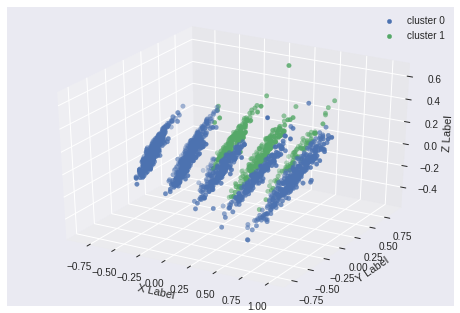

In [54]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components = 3)
users_dataset_components = pca_model.fit_transform(train.drop("label", axis = 1).values)

fig = plot_clusters(create_clusters(users_dataset_components, train.label))

# KNN regressor classifier model

# KNN with train clusters

In [61]:
knn_regressor = KNeighborsRegressor(n_neighbors=30,weights = 'distance')
knn_regressor.fit(train.drop("label", axis = 1), train["label"])

test["label"] = knn_regressor.predict(test.drop("label", axis=1))

test.head()

,MeanTextSize,NumberProducts,MeanDifferenceScoreBySentimentRate,VarianceDifferenceScoreBySentimentRate,GroupLike,GroupDesLike,MeanReviewsWithLikes,MeanDiffUserScoreToProductScore,VarianceDiffUserScoreToProductScore,MeanLikeParticipation,label
UserId,,,,,,,,,,,
A264UDLWWRJ7X4,0.180030,0.006757,0.257188,0.019377,0.75,0.75,0.500000,0.204261,0.024405,0.326903,2.0
A35VI0H5AFHOJ5,0.285679,0.003378,0.274473,0.027592,1.00,0.00,0.727273,0.179244,0.027029,0.375009,0.0
A3FD3BHIUYIFPD,0.078017,0.020270,0.160462,0.015538,0.00,0.75,0.187500,0.157521,0.009040,0.003596,1.0
A9ESHA5MS6S6L,0.019264,0.003378,0.358944,0.021066,0.00,0.75,0.181818,0.218196,0.008125,0.004861,1.0
A2D1LPEUCTNT8X,0.226498,0.185811,0.285476,0.017032,0.75,0.00,0.538462,0.079549,0.012997,0.294747,0.0


# KNN with clusters centroids

In [33]:
knn_regressor_centers = KNeighborsRegressor(n_neighbors = 2, weights = 'distance')
knn_regressor_centers.fit(kmeans_model.cluster_centers_ , [0, 1, 2, 3])

test_centroids["label*"] = knn_regressor_centers.predict(test_centroids)
print(kmeans_model.cluster_centers_)
test_centroids.head(5)

,MeanTextSize,NumberProducts,MeanDifferenceScoreBySentimentRate,VarianceDifferenceScoreBySentimentRate,GroupLike,GroupDesLike,MeanReviewsWithLikes,MeanDiffUserScoreToProductScore,VarianceDiffUserScoreToProductScore,MeanLikeParticipation,label*
UserId,,,,,,,,,,,
A2CZ98V784SRJ0,0.140036,0.013514,0.260426,0.023886,0.25,0.50,0.357143,0.157236,0.026030,0.073040,2.576427
ASW22V6LI995Z,0.106322,0.006757,0.169470,0.013085,0.75,0.75,0.333333,0.182083,0.019662,0.119157,1.576513
A20P8VC55KPPCT,0.049982,0.030405,0.259399,0.004427,0.25,0.00,0.315789,0.069376,0.003019,0.047571,1.687280
A32T2H8150OJLU,0.294878,0.037162,0.208411,0.023228,0.50,0.75,0.428571,0.087497,0.008868,0.164299,1.968648
A2B7BUH8834Y6M,0.116401,0.027027,0.334158,0.005964,1.00,0.75,0.888889,0.044611,0.005148,0.783929,0.366318
